In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

df = pd.read_csv('/kaggle/input/wind-dataset/T1.csv')
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


TASK-1: EDA

Missing values: Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64


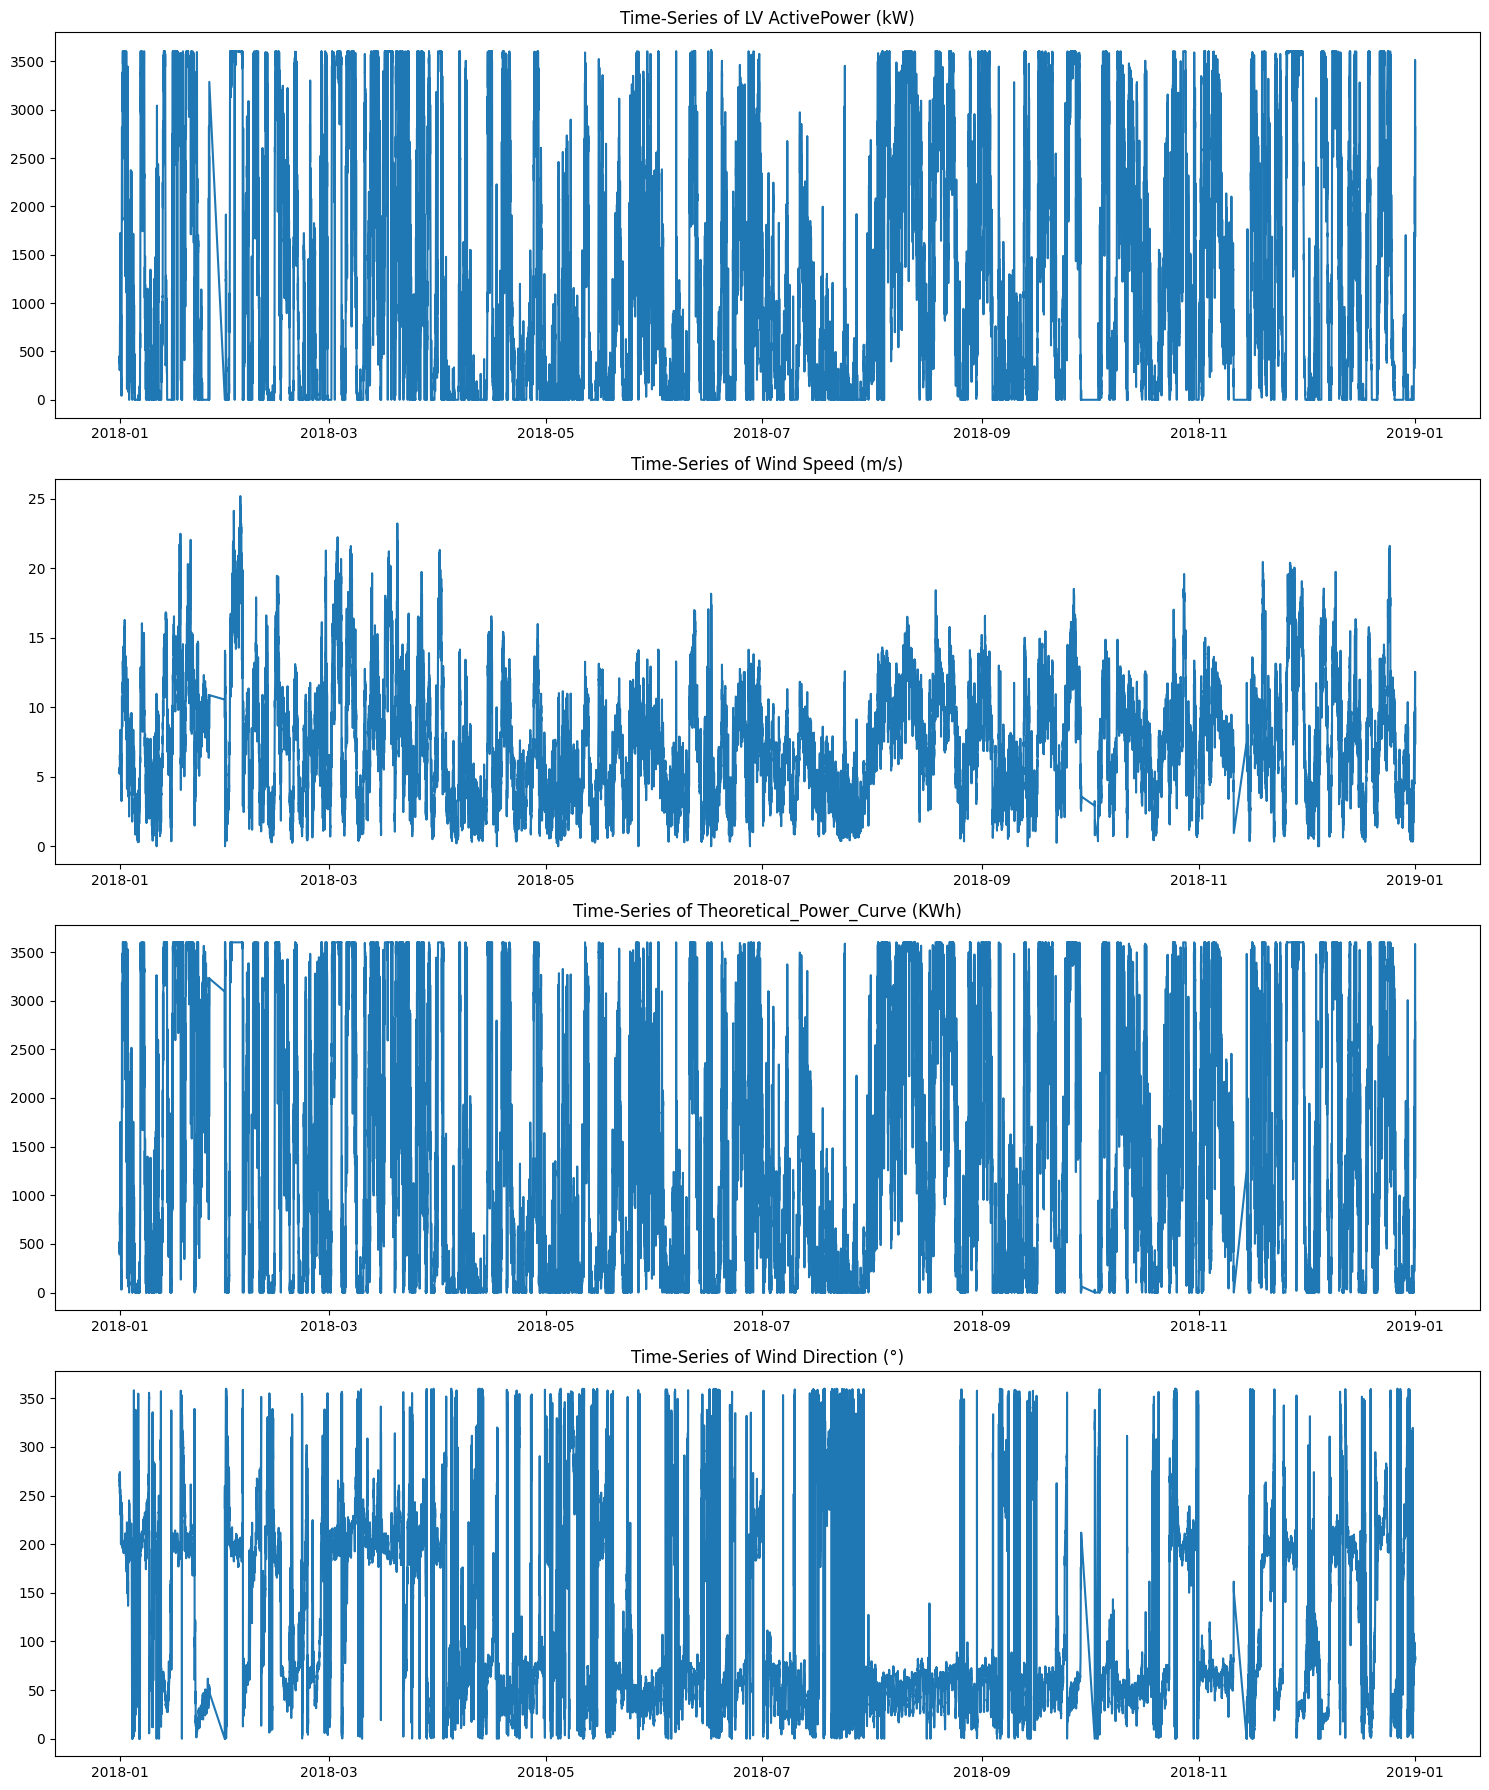

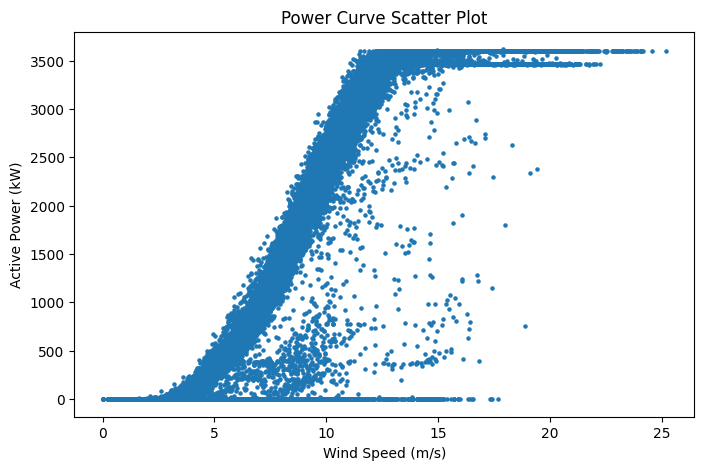

In [5]:
try:
    df['Date/Time'] = pd.to_datetime(df['Date/Time'], format="%d %m %Y %H:%M")
except:
    df['Date/Time'] = pd.to_datetime(df['Date/Time'], dayfirst=True, format='mixed')

df = df.sort_values('Date/Time')

print("Missing values:", df.isnull().sum())

fig, axes = plt.subplots(4, 1, figsize=(15, 18))

cols = ["LV ActivePower (kW)", "Wind Speed (m/s)", 
        "Theoretical_Power_Curve (KWh)", "Wind Direction (°)"]

for i, col in enumerate(cols):
    axes[i].plot(df['Date/Time'], df[col])
    axes[i].set_title(f"Time-Series of {col}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(df["Wind Speed (m/s)"], df["LV ActivePower (kW)"], s=5)
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Active Power (kW)")
plt.title("Power Curve Scatter Plot")
plt.show()



TASK-2: Supervised Learning (Forecasting 4 Variables)

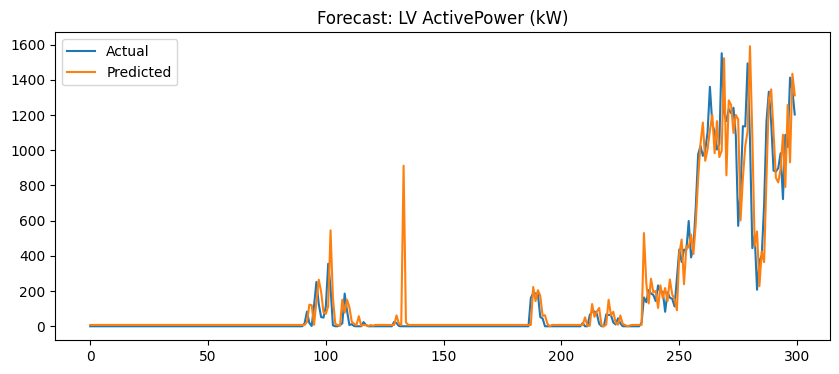


LV ActivePower (kW) → MAE=139.563, RMSE=240.888



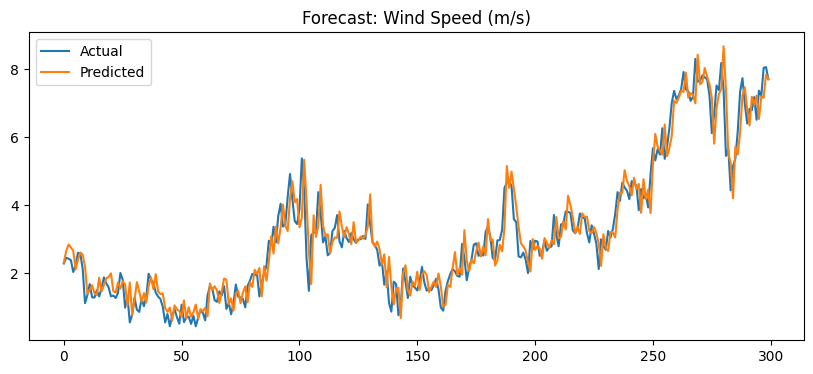


Wind Speed (m/s) → MAE=0.575, RMSE=0.782



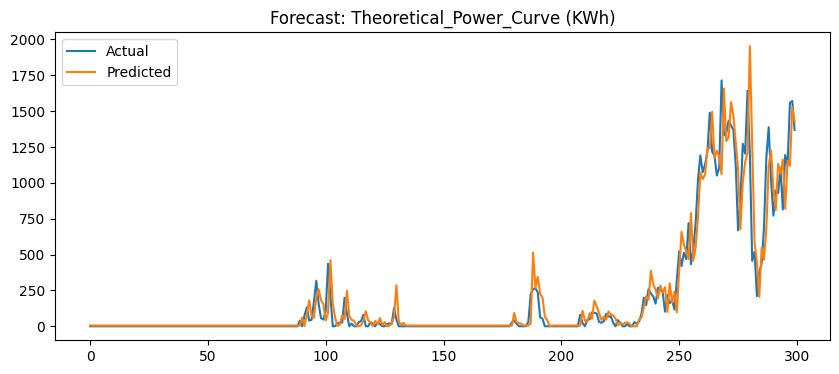


Theoretical_Power_Curve (KWh) → MAE=173.739, RMSE=291.815



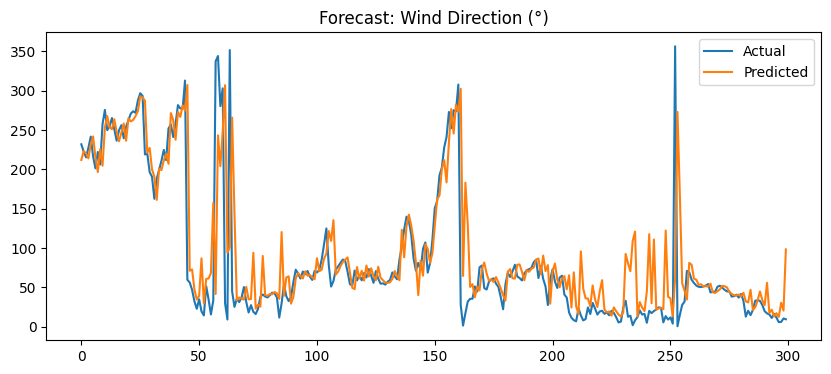


Wind Direction (°) → MAE=11.661, RMSE=36.182



In [6]:
def create_window_data(series, window=3):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(X), np.array(y)

results = {}

variables = {
    "ActivePower": "LV ActivePower (kW)",
    "WindSpeed": "Wind Speed (m/s)",
    "TheoreticalPower": "Theoretical_Power_Curve (KWh)",
    "WindDirection": "Wind Direction (°)",
}

for key, col in variables.items():

    data = df[col].values
    X, y = create_window_data(data, window=3)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    model = RandomForestRegressor(n_estimators=150)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    results[key] = {"model": model, "preds": preds, "y_test": y_test,
                    "MAE": mae, "RMSE": rmse}

    plt.figure(figsize=(10,4))
    plt.plot(y_test[:300], label="Actual")
    plt.plot(preds[:300], label="Predicted")
    plt.title(f"Forecast: {col}")
    plt.legend()
    plt.show()

    print(f"\n{col} → MAE={mae:.3f}, RMSE={rmse:.3f}\n")


TASK 3 — Unsupervised Learning (Anomaly Detection)

Total anomalies detected: 1629


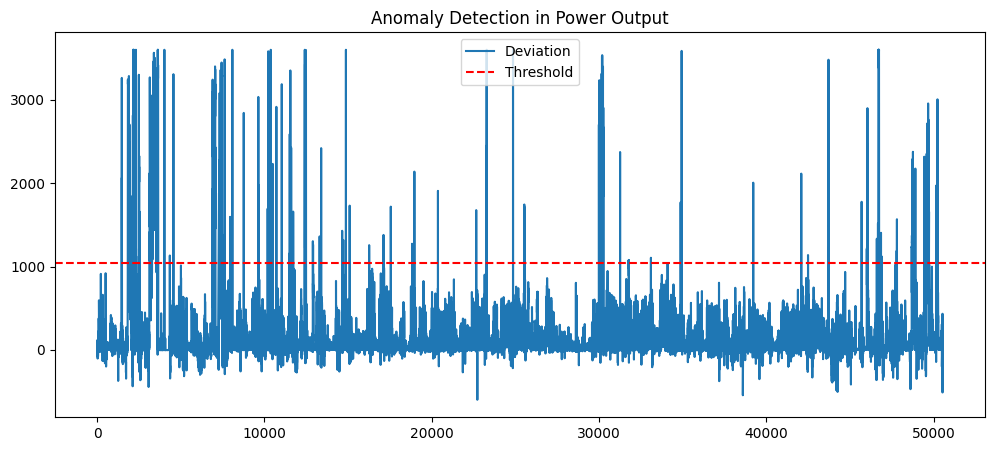

In [8]:
df['Power_Deviation'] = df["Theoretical_Power_Curve (KWh)"] - df["LV ActivePower (kW)"]

threshold = df['Power_Deviation'].mean() + 2 * df['Power_Deviation'].std()
df['Anomaly'] = df['Power_Deviation'] > threshold

print("Total anomalies detected:", df['Anomaly'].sum())

# Plot
plt.figure(figsize=(12,5))
plt.plot(df["Power_Deviation"], label="Deviation")
plt.axhline(threshold, color='red', linestyle='--', label="Threshold")
plt.title("Anomaly Detection in Power Output")
plt.legend()
plt.show()


TASK 4 — AI Task (Performance Score Generator)

In [9]:
df['Performance_Ratio'] = df["LV ActivePower (kW)"] / (
    df["Theoretical_Power_Curve (KWh)"] + 1e-6
)

df['Performance_Score'] = (df['Performance_Ratio'] * 100).clip(0, 100)

def categorize(score):
    if score > 75:
        return "Good"
    elif score > 40:
        return "Moderate"
    else:
        return "Poor"

df['Performance_Category'] = df['Performance_Score'].apply(categorize)

df[['LV ActivePower (kW)', 
    'Theoretical_Power_Curve (KWh)', 
    'Performance_Score', 
    'Performance_Category']].head()


,LV ActivePower (kW),Theoretical_Power_Curve (KWh),Performance_Score,Performance_Category
0,380.047791,416.328908,91.285467,Good
1,453.769196,519.917511,87.277152,Good
2,306.376587,390.900016,78.377225,Good
3,419.645905,516.127569,81.306624,Good
4,380.650696,491.702972,77.414764,Good


In [10]:
def suggestion(score):
    if score > 75:
        return "Turbine is performing well. No action needed."
    elif score > 40:
        return "Moderate performance. Inspect blade angle and minor losses."
    else:
        return "Severe underperformance! Check gearbox, blades, generator."

df['Suggestion'] = df['Performance_Score'].apply(suggestion)

df[['Performance_Score', 'Performance_Category', 'Suggestion']].head()


,Performance_Score,Performance_Category,Suggestion
0,91.285467,Good,Turbine is performing well. No action needed.
1,87.277152,Good,Turbine is performing well. No action needed.
2,78.377225,Good,Turbine is performing well. No action needed.
3,81.306624,Good,Turbine is performing well. No action needed.
4,77.414764,Good,Turbine is performing well. No action needed.


Actual power vs theoretical :

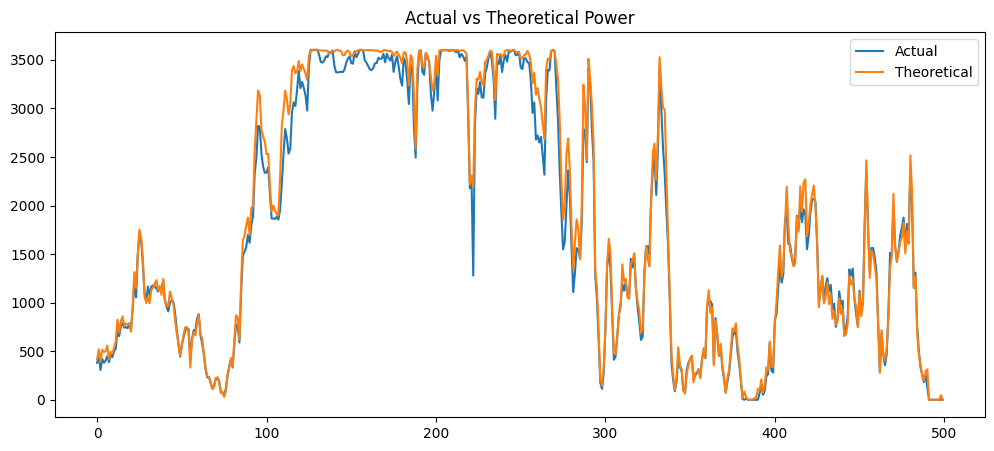

In [11]:
plt.figure(figsize=(12,5))
plt.plot(df['LV ActivePower (kW)'].iloc[:500], label="Actual")
plt.plot(df['Theoretical_Power_Curve (KWh)'].iloc[:500], label="Theoretical")
plt.legend()
plt.title("Actual vs Theoretical Power")
plt.show()


percetage of underperformance :

In [18]:
df['Underperformance_Percentage'] = (
    (df["Theoretical_Power_Curve (KWh)"] - df["LV ActivePower (kW)"]) /
    (df["Theoretical_Power_Curve (KWh)"] + 1e-6)
) * 100

df[['LV ActivePower (kW)', 
    'Theoretical_Power_Curve (KWh)', 
    'Underperformance_Percentage']].head()


,LV ActivePower (kW),Theoretical_Power_Curve (KWh),Underperformance_Percentage
0,380.047791,416.328908,8.714532
1,453.769196,519.917511,12.722848
2,306.376587,390.900016,21.622774
3,419.645905,516.127569,18.693375
4,380.650696,491.702972,22.585236
